In [1]:
%pylab inline
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

# Project 5
**Your group member:**

- The deadline is May 7th 11:59pm. Submission after the deadline will not be graded.

- This is a group projection. Your group only needs to submit one project. You can form a group of 1, 2 or 3.

- Submit your work(your reasoning and your code) as a SINGLE .ipynb document. Please rename the document as _HW1_YOURNAME.ipynb_ (for example, _HW1_FELIX.ipynb_). You are responsible for checking that you have correctly submitted the correct document. If your code cannot run, you may receive NO point.


- Please justify all short answers with a brief explanation.

- You only use the Python packages included in the following cell. You are not allowed to use other advanced package or modules unless you are permitted to.

- In your final submission include the plots produced by the unedited code as presented below, as well as any additional plots produced after editing the code during the course of a problem. You may find it necessary to copy/paste relevant code into additional cells to accomplish this.

- Feel free to use the lecture notes and other resources.


- **You must write your own code and fill in the your answer in the text box.** If you fail to do either of that, you will receive zero point.






---




# Image classification on CIFAR-10


### Preliminaries information:
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10
dataset. If you are not comfortable with PyTorch from the previous lecture and discussion materials, use the tutorials at http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html and make sure you
are familiar with tensors, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`),
ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

For this problem, it is highly recommended that you copy and modify the existing network code produced in
the tutorial *Training a classifier*. You should not be coding this network from scratch!



- Each network $f$ maps an image $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$ (3 channels for RGB) to an output $f(x^{\rm in}) = x^{\rm out} \in \mb{R}^{10}$. The class label is predicted as $\arg\max_{i=0,1,\dots,9} x_{i}^{\rm out}$.

- The network is trained via multiclass cross-entropy loss (log of softmax function).  Specifically, for an input image and label pair $(x^{\rm in} , c)$ where $c\in \{0,\dots, 9\}$. If the network’s
output layer is $x^{\rm out} \in \mb{R}^{10}$, the loss $-\log\left(\frac{\exp(x_c^{\rm out})}{\sum_{c'} \exp(x_{c'}^{\rm out})}\right)$.

- For computational efficiency reasons, this particular network considers mini-batches of images per training
step meaning the network actually maps $B=4$ images per feed-forward so that $\tilde{x}^{\rm in}\in\mb{R}^{B\times 32 \times 32 \times 3}$ and $\tilde{x}^{\rm out}\in\mb{R}^{B\times 10}$.  This is ignored in the network descriptions below but it is something to be aware of.

- Create a validation dataset by appropriately partitioning the train dataset. **Hint**: look at the documentation for `torch.utils.data.random\_split`. Make sure to tune hyperparameters like network architecture and step size on the validation dataset. Do **NOT** validate your hyperparameters on the test dataset.

- Modify the training code such that at the end of each epoch (one pass over the training data) it computes and prints the training and test classification accuracy.

- The cross-entropy loss for a neural network is, in general, non-convex. This means that the optimization
method may converge to different local minima based on different hyperparameters of the optimization
procedure (e.g., stepsize). Usually one can find a good setting for these hyperparameters by just observing
the relative progress of training over the first epoch or two (how fast is it decreasing) but you are warned
that early progress is not necessarily indicative of the final convergence value (you may converge quickly to a poor local minimum whereas a different step size could have poor early performance but converge to
a better final value).

- While one would usually train a network for hundreds of epochs to reach convergence and maximize accuracy, this can be prohibitively time-consuming, so feel free to train for just a a dozen or so epochs.


**Your Task:**
For all of the following,
- Apply a **hyperparameter tuning method** (manually by
hand, grid search, random search, etc.) using the
validation set

- Report the hyperparameter configurations you evaluated and the best set of hyperparameters
from this set.  

- Plot the training and validation classification accuracy as a function of iteration. Produce
a separate line or plot for each hyperparameter configuration evaluated (please try to use multiple lines in a single plot to keep the number of figures minimal).

- Finally, evaluate your best set of
hyperparameters on the test data and report the accuracy.



The number of hyperparameters to tune, combined with the slow training times, will hopefully give
you a taste of how difficult it is to construct networks with good generalization performance. It should be emphasized that the
networks we constructed are **tiny**.
State-of-the-art networks can have dozens of layers, each with their own hyperparameters to tune. Additional
hyperparameters you are welcome to play with if you are so inclined, include: changing the activation
function, replace max-pool with average-pool, adding more convolutional or fully connected layers, and
experimenting with batch normalization or dropout.


Here are the network architectures you will construct and compare.
Before you jump into tuning, it is better to write  separate train and evaluation functions.

---







In [2]:
sns.set()
torch.manual_seed(592)
np.random.seed(592)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [31]:
# it may takes while to download the data, please try this code several times.
def prepare_dataset(batch_size=64, train_val_split_ratio=0.9, resize=False):

    if resize:
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    cifar10_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(cifar10_set) * train_val_split_ratio)
    val_size   = len(cifar10_set) - train_size

    cifar10_trainset, cifar10_valset = torch.utils.data.random_split(cifar10_set, [train_size, val_size])
    cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(cifar10_valset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


In [33]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_loader, val_loader, test_loader = prepare_dataset()

## Finish the following code (10pt)
Please finish the functions of `train` and `evaluation`. You must use these two functions in the later evaluation. Fail to do so will result zero point in your project.

In [5]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs,
          device=device, updates=True):
    """
    Trains a model for n epochs using given optimizer, and then records
    validation and training accuracies, validation and training losses.
    """
    # Your code starts here.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        ## training set
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            ## end training loop

        print(f'Epoch {epoch + 1}')
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(evaluation(model, train_loader, criterion))
        if updates:
            print(f'Training loss: {train_losses[-1]}')
            print(f'Training accuracy: {train_accuracies[-1]}%')

        model.eval()
        ## validation set
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                ## end train loop

        val_losses.append(running_loss / len(val_loader))
        print(f'Validation loss: {val_losses[-1]}')
        val_accuracies.append(evaluation(model, val_loader, criterion))
        print(f'Validation accuracy: {val_accuracies[-1]}%')
        print()

        ## end epoch loop

    print('Finished Training')
    return train_losses, train_accuracies, val_losses, val_accuracies

def evaluation(model, test_loader, criterion, device=device):
    """
    Calculate and print test accuracy and test losses.
    """
    correct = 0
    total = 0
    num_data = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            num_data += 1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ## end data loop

    accuracy = 100 * correct // total
    return accuracy

def plots(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plot training and validation losses and accuracies.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(train_losses, label='Training loss')
    ax[0].plot(val_losses, label='Validation loss')
    ax[0].legend()
    ax[1].plot(train_accuracies, label='Training accuracy')
    ax[1].plot(val_accuracies, label='Validation accuracy')
    ax[1].legend()
    plt.title('Training and validation loss and accuracy')
    plt.show()



##  Fully-connected output, no hidden layers (logistic regression) (10pt)
We begin with the simplest network
possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is,
conceptually it could be written as
\begin{align*}
    x^{\rm out} &= W \text{vec}(x^{\rm in}) +b
\end{align*}
where $x^{\rm out} \in \mb{R}^{10}$, $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$, $W \in \mb{R}^{10 \times 3072}$, $b \in \mb{R}^{10}$ since $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mb{R}^{a \times b \times c}$, we let $\text{vec}(x) \in \mb{R}^{a b c}$ be the reshaped form of the tensor into a vector (in an arbitrary but consistent pattern).   There is no required benchmark testing accuracy for this part.

In [ ]:
#  your code starts here

class simpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

simple_model = simpleModel()

Epoch 1
Training loss: 1.8478167973120103
Training accuracy: 39%
Validation loss: 1.7883086974107767
Validation accuracy: 38%

Epoch 2
Training loss: 1.757513939487663
Training accuracy: 41%
Validation loss: 1.7713214053383357
Validation accuracy: 39%

Epoch 3
Training loss: 1.7308702878654003
Training accuracy: 42%
Validation loss: 1.7471655139440223
Validation accuracy: 40%

Epoch 4
Training loss: 1.7133784102783962
Training accuracy: 42%
Validation loss: 1.7458976054493385
Validation accuracy: 40%

Epoch 5
Training loss: 1.6990919792178003
Training accuracy: 42%
Validation loss: 1.7385431588450564
Validation accuracy: 40%

Epoch 6
Training loss: 1.6925784315575252
Training accuracy: 42%
Validation loss: 1.7346585853190362
Validation accuracy: 40%

Epoch 7
Training loss: 1.6846870041706345
Training accuracy: 43%
Validation loss: 1.7274153987063636
Validation accuracy: 40%

Epoch 8
Training loss: 1.6773647179996425
Training accuracy: 43%
Validation loss: 1.7292015733598154
Validation 

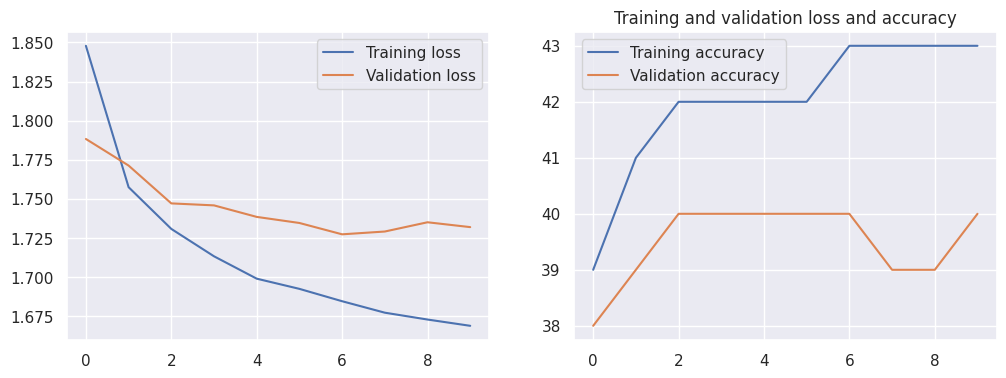

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters(), lr=0.001, momentum=0.9)
epochs=10

graphing_simple = train(simple_model, train_loader, val_loader,
                        criterion, optimizer, epochs, updates=False)
test_accuracy = evaluation(simple_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_simple)

### Discuss your findings:

After $10$ epochs, our final epoch had a training loss of ~$1.67$ with a training accuracy of ~$44\%$ and a final testing accuracy of ~$40\%$ (slight variance from run to run, but the ballpark is the same).



---


## Fully-connected output, 1 fully-connected hidden layer (10pt)

We will have one hidden layer denoted as $x^{\rm hidden} \in \mb{R}^{M}$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The non-linearity applied to the hidden layer will be the **relu** ($\mathrm{relu}(x) = \max\{0,x\}$, elementwise). This network can be written as

\begin{align*}
    x^{\rm out} &= W_2 \mathrm{relu}(W_1 \text{vec}(x^{\rm in}) +b_1) + b_2
\end{align*}

where $W_1 \in \mb{R}^{M \times 3072}$, $b_1 \in \mb{R}^M$, $W_2 \in \mb{R}^{10 \times M}$, $b_2 \in \mb{R}^{10}$.  Tune the different hyperparameters and train for
a sufficient number of epochs to achieve a testing accuracy of at least 50%. Provide the hyperparameter
configuration used to achieve this performance.



In [ ]:
#  your code starts here

class oneHiddenModel(nn.Module):

    def __init__(self, M):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3072, M)
        self.linear2 = nn.Linear(M, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


Epoch 1
Training loss: 1.897908521985466
Training accuracy: 40%
Validation loss: 1.7410268949556955
Validation accuracy: 39%

Epoch 2
Training loss: 1.6728377536955206
Training accuracy: 44%
Validation loss: 1.6324248766597313
Validation accuracy: 43%

Epoch 3
Training loss: 1.5879590311510996
Training accuracy: 46%
Validation loss: 1.5815167472332339
Validation accuracy: 44%

Epoch 4
Training loss: 1.532164374535734
Training accuracy: 48%
Validation loss: 1.5520040309881862
Validation accuracy: 45%

Epoch 5
Training loss: 1.4851575974713673
Training accuracy: 50%
Validation loss: 1.5068894851056835
Validation accuracy: 46%

Epoch 6
Training loss: 1.4471255252984436
Training accuracy: 51%
Validation loss: 1.5011663391620298
Validation accuracy: 47%

Epoch 7
Training loss: 1.4098939372395927
Training accuracy: 52%
Validation loss: 1.4630023271222659
Validation accuracy: 48%

Epoch 8
Training loss: 1.3770895475860347
Training accuracy: 53%
Validation loss: 1.4398368144337135
Validation a

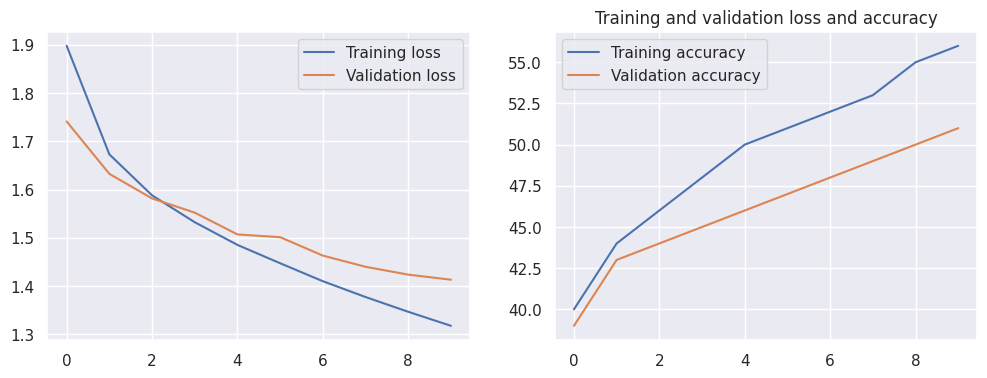

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 10

one_hidden_model = oneHiddenModel(M=500)
optimizer = optim.SGD(one_hidden_model.parameters(), lr=0.001, momentum=0.9)

graphing_one_hidden = train(one_hidden_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=False)
test_accuracy = evaluation(one_hidden_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_one_hidden)

### Discuss your findings:

We trained setting our epochs to $3$ as we ran with different sized hidden layers $([50,700])$ until we got a decent training accuracy. We found that after the first $3$ epochs, increasing by $50$ for each run, we got a steady output for $M\in [300, 700]$. We then increased the epochs to $5$ while increasing by $25$ per run on this interval to find further improvement.

We find that the difference between the accuracies are negligible in this interval, so we choose $M=500$ for the model with an epochs of $10$. We get a testing accuracy of ~$51\%$ with these settings (increasing epochs to $11$ or $12$ will guarentee the accuracy be above $50\%$).



---


## Convolutional layer with max-pool and fully-connected output (15pt)

For a convolutional layer $W_1$ with filters of size $k \times k \times 3$, and $M$ filters (reasonable choices are $M=100$, $k=5$), we have that $\mathrm{Conv2d}(x^{\rm in}, W_1) \in \mb{R}^{(33-k) \times (33-k) \times M}$.

- Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as $\mathrm{Conv2d}(x^{\rm in}, W) + b_1$ where $b_1$ is parameterized in $\mb{R}^M$. Apply a **relu** activation to the result of the convolutional layer.

-  Next, use a max-pool of size $N \times N$ (a reasonable choice is $N=14$ to pool to $2 \times 2$ with $k=5$) we have that $\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm in}, W_1)+b_1)) \in \mb{R}^{\lfloor\frac{33-k}{N}\rfloor \times \lfloor\frac{33-k}{N}\rfloor \times M}$.

- We will then apply a fully-connected layer to the output to get a final network given as
\begin{align*}
          x^{\rm output} = W_2 \text{vec}(\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm input}, W_1)+b_1))) + b_2
\end{align*}
where $W_2 \in \mb{R}^{10 \times M (\lfloor\frac{33-k}{N}\rfloor)^2}$, $b_2 \in \mb{R}^{10}$.


The parameters $M, k, N$ (in addition to the step size and momentum) are all hyperparameters, but you
can choose a reasonable value. Tune the different hyperparameters (number of convolutional filters, filter
sizes, dimensionality of the fully-connected layers, stepsize, etc.) and train for a sufficient number of
epochs to achieve a validation accuracy of **at least 70%**. Provide the hyperparameter configuration used
to achieve this performance. Make sure to save this model so that you can do the next part.


In [8]:
class convModel(nn.Module):
    def __init__(self, M, k, N, step_size=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, M, k, step_size)
        self.pool = nn.MaxPool2d(N, N)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(M*((33-k)//N)**2, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

Current Run:
M=180, k=7, N=13, learning rate=0.0012 momentum=0.98 

Epoch 1
Training loss: 1.7212134660644964
Training accuracy: 49%
Validation loss: 1.4385417247120338
Validation accuracy: 49%

Epoch 2
Training loss: 1.3655956635590305
Training accuracy: 56%
Validation loss: 1.2618440050113051
Validation accuracy: 56%

Epoch 3
Training loss: 1.2364021273837849
Training accuracy: 57%
Validation loss: 1.249853893171383
Validation accuracy: 56%

Epoch 4
Training loss: 1.1769683995199474
Training accuracy: 60%
Validation loss: 1.1780860537215123
Validation accuracy: 59%

Epoch 5
Training loss: 1.1140023329379884
Training accuracy: 63%
Validation loss: 1.0995934507514857
Validation accuracy: 61%

Epoch 6
Training loss: 1.0674891098487107
Training accuracy: 64%
Validation loss: 1.085076478463185
Validation accuracy: 62%

Epoch 7
Training loss: 1.0301349630410022
Training accuracy: 63%
Validation loss: 1.1274208683001845
Validation accuracy: 61%

Epoch 8
Training loss: 1.0097873359071938
Tra

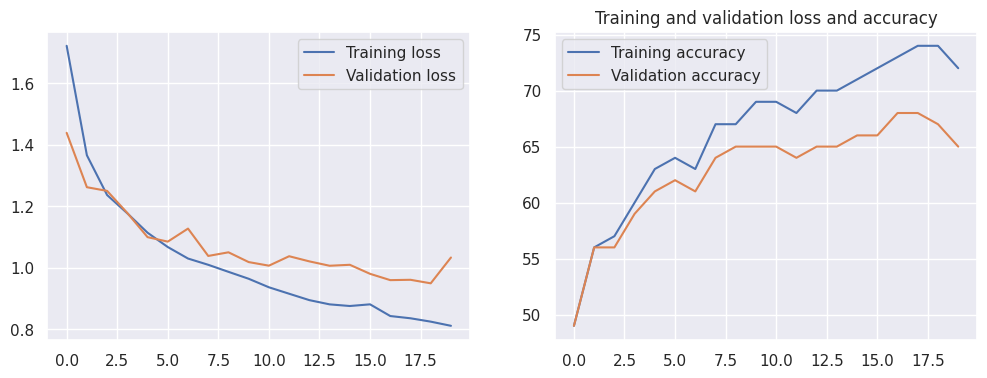

In [38]:
criterion = nn.CrossEntropyLoss()
epochs = 20

M=180
k=7
N=13
mom=.98
learn_rate=.0012
print("Current Run:")
print(f"M={M}, k={k}, N={N}, learning rate={learn_rate} momentum={mom} \n")

conv_model = convModel(M=M, k=k, N=N)
conv_model = conv_model.to(device)
optimizer = optim.SGD(conv_model.parameters(), lr=learn_rate, momentum=mom)

graphing_conv = train(conv_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)
test_accuracy = evaluation(conv_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_conv)

### Obsolete Hyperparameter attempts

Epoch 1
Training loss: 2.059561625969681
Training accuracy: 33%
Validation loss: 1.9095345614831658
Validation accuracy: 33%

Epoch 2
Training loss: 1.8296476180919192
Training accuracy: 38%
Validation loss: 1.7660791889021668
Validation accuracy: 38%

Epoch 3
Training loss: 1.7088556801053612
Training accuracy: 41%
Validation loss: 1.6667697686183303
Validation accuracy: 40%

Finished Training
Test accuracy: 40%


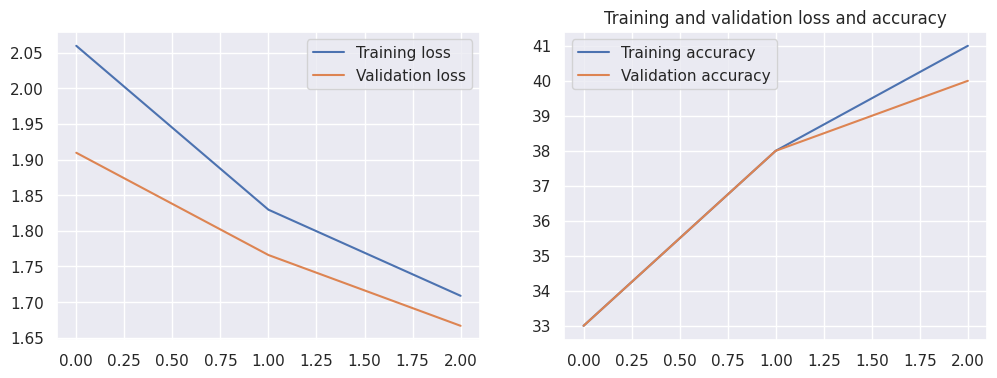

In [ ]:
"""
# better hyperparameters found
criterion = nn.CrossEntropyLoss()
epochs = 3

conv_model = convModel(M=100, k=5, N=14)
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.90)

graphing_conv = train(conv_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)
test_accuracy = evaluation(conv_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_conv)
"""

Epoch 1
Training loss: 1.8991034606640989
Training accuracy: 40%
Validation loss: 1.694409987594508
Validation accuracy: 39%

Epoch 2
Training loss: 1.6045571152459492
Training accuracy: 47%
Validation loss: 1.5225631149509284
Validation accuracy: 47%

Epoch 3
Training loss: 1.4683826868845657
Training accuracy: 50%
Validation loss: 1.4147899678990812
Validation accuracy: 50%

Epoch 4
Training loss: 1.3779261803085154
Training accuracy: 54%
Validation loss: 1.3460661746278595
Validation accuracy: 53%

Epoch 5
Training loss: 1.313477145423266
Training accuracy: 55%
Validation loss: 1.3036835374711435
Validation accuracy: 55%

Epoch 6
Training loss: 1.2612873692573472
Training accuracy: 57%
Validation loss: 1.2568410189845893
Validation accuracy: 56%

Epoch 7
Training loss: 1.2220772674984552
Training accuracy: 58%
Validation loss: 1.2343493518950064
Validation accuracy: 57%

Epoch 8
Training loss: 1.1919509003954856
Training accuracy: 60%
Validation loss: 1.2016671677178974
Validation a

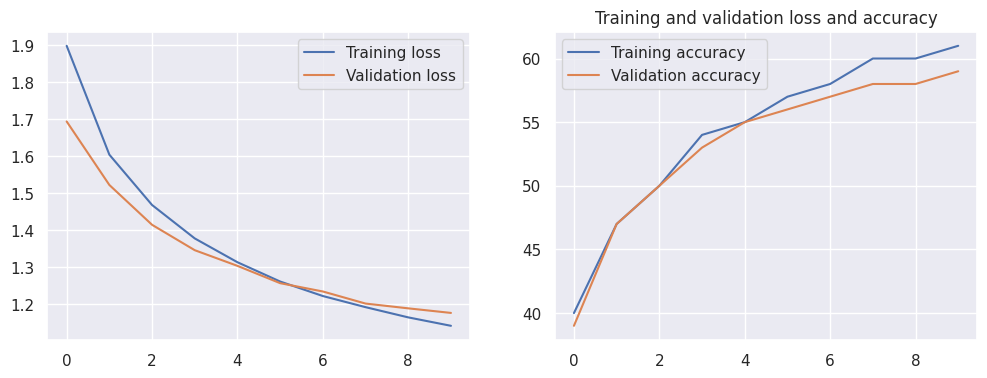

In [ ]:
"""
# better hyperparameters found
criterion = nn.CrossEntropyLoss()
epochs = 10

conv_model = convModel(M=120, k=7, N=13)
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.95)

graphing_conv = train(conv_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)
test_accuracy = evaluation(conv_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_conv)
"""

In [ ]:
"""
# better hyperparameters found
criterion = nn.CrossEntropyLoss()
epochs = 10

conv_model = convModel(M=150, k=5, N=14)
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.95)

graphing_conv = train(conv_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)
test_accuracy = evaluation(conv_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_conv)
"""

"\n# better hyperparameters found\ncriterion = nn.CrossEntropyLoss()\nepochs = 10\n\nconv_model = convModel(M=150, k=5, N=14)\noptimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.95)\n\ngraphing_conv = train(conv_model, train_loader, val_loader,\n                                criterion, optimizer, epochs, updates=True)\ntest_accuracy = evaluation(conv_model, test_loader, criterion)\nprint(f'Test accuracy: {test_accuracy}%')\nplots(*graphing_conv)\n"

### Discuss your findings:

**Rewrite this after validation implimentation**

After the initial run with $M=100, k=5$ and $N=14$, our testing accuracy was around $50\%$. We ventured to adapt our $k$ and $N$ values to other combinations that would still allow for $\lfloor{(33-k)/N}\rfloor = 2$, which gives us $k=3, N=15$, $k=7,N=13$, $k=9,N=12$ and so on. We found that $k=7,N=13$ performs very well, so we kept it static.

We then changed the momentum parameter in the SGD optimizer, and found that increasing it vastly improves out training accuracy per epoch, leading to a massive improvement in testing accuracy. After seeing improvements at $.95$, we increased it to $.98$. This yielded a testing accuracy over $60\%$.

We then checked for any changes in increasing $M$, as that improved our previous model. The same held here, but more marginally than we would like, but with $M=180$ and all other changes, our model was able to reach high $60\%$ validation accuracy, with one run reaching $70\%$. This likely had much to do with momentum carrying our model in the correct direction by chance, as most training runs with this configuration ended at $65-68\%$.



In [39]:
# saving model
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/ualbany courses/ML Practicum/hw5")

PATH = './cifar_conv.pth'
torch.save(conv_model.state_dict(), PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---


## More tuning (20pt)

Return to the original network you were left with at the end of the tutorial Training
a classifier. (Note that this is not the network above.) Tune the different hyperparameters
(number of convolutional filters, filter sizes, dimensionality of the fully-connected layers, stepsize, etc.) and
train for a sufficient number of iterations to achieve a *train accuracy* of **at least 87%**. You may not modify
the core structure of the model (i.e., adding additional layers). Provide the hyperparameter configuration
used to achieve this performance. Make sure to save this model so that you can do the next part (see
the Training a classifier tutorial for details on how to do this).

In [6]:
class netModel(nn.Module):

    def __init__(self, M1=6, M2=16, L1=120, L2=84):
        super().__init__()
        self.conv1 = nn.Conv2d(3, M1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(M1, M2, 5)
        self.fc1 = nn.Linear(M2 * 5 * 5, L1)
        self.fc2 = nn.Linear(L1, L2)
        self.fc3 = nn.Linear(L2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1
Training loss: 2.0945545885373247
Training accuracy: 34%
Validation loss: 1.811123013496399
Validation accuracy: 34%

Epoch 2
Training loss: 1.6170098068700596
Training accuracy: 46%
Validation loss: 1.5021453371530846
Validation accuracy: 46%

Epoch 3
Training loss: 1.4054805375635624
Training accuracy: 52%
Validation loss: 1.3344766474977325
Validation accuracy: 52%

Epoch 4
Training loss: 1.266157883473418
Training accuracy: 55%
Validation loss: 1.2582840180095238
Validation accuracy: 54%

Epoch 5
Training loss: 1.1494639793580228
Training accuracy: 61%
Validation loss: 1.117784177955193
Validation accuracy: 60%

Epoch 6
Training loss: 1.0639812681315974
Training accuracy: 65%
Validation loss: 1.0622250550909886
Validation accuracy: 62%

Epoch 7
Training loss: 0.9706176035106182
Training accuracy: 68%
Validation loss: 0.9855553983133051
Validation accuracy: 64%

Epoch 8
Training loss: 0.8988139660690319
Training accuracy: 71%
Validation loss: 0.938021384085281
Validation acc

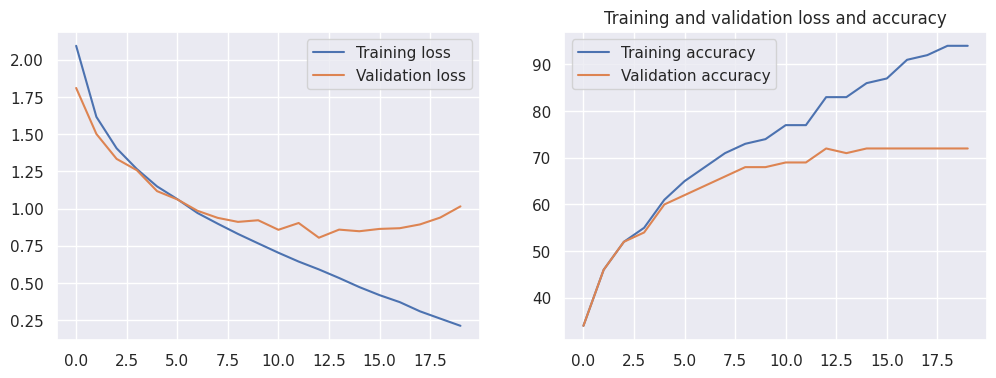

In [7]:
criterion = nn.CrossEntropyLoss()
epochs = 20

net_model = netModel(M1=64, M2=128, L1=300, L2=150)
optimizer = optim.SGD(net_model.parameters(), lr=0.001, momentum=0.95)

graphing_net = train(net_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)
test_accuracy = evaluation(net_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_net)

### Discuss your findings:

Running with fairly simple choices for our hyperparameters, we get a training accuracy of $87\%$ after $16$ epochs, ending with $95\%$ training accuracy after $20$. The configuration we found for this is (assuming the convention for filter numbers as $M$ and hidden layer sizing a $L$) $M_1 = 64, M_2 = 128$ and $L_1 = 300, L_2 = 150$, with momentum set to $.95$.

This gives us the impression that adding more well tuned convolution layers to our neural network will typically allow for better classifications, typically at the cost to training runtime. However, it is clear that by running for more epochs than we need to, we begin to overfit the model, as the validation loss begins to increase after a certain number of epochs.

In [12]:
# saving model
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/ualbany courses/ML Practicum/hw5")

PATH = './cifar_net.pth'
torch.save(net_model.state_dict(), PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---

## Transfer Learning:  Use AlexNet as a fixed feature extractor (10pt)
So far we have trained very small neural networks from scratch. As mentioned in the previous problem,
modern neural networks are much larger and more difficult to train and validate. In practice, it is rare to train
such large networks from scratch. This is because it is difficult to obtain both the massive datasets and the
computational resources required to train such networks.

Instead of training a network from scratch, in this problem, we will use a network that has already been trained
on a very large dataset (ImageNet) and adjust it for the task at hand. This process of adapting weights in a
model trained for another task is known as **transfer learning**.

Begin with the pretrained **AlexNet** model from `torchvision.models` for the following tasks below. AlexNet
achieved an early breakthrough performance on ImageNet and was instrumental in sparking the deep
learning revolution in 2012.

Do not modify any module within AlexNet that is not the final classifier layer.

- The output of AlexNet comes from the 6-th layer of the classifier. Specifically, `model.classifer[6] =
nn.Linear(4096, 1000)`. To use AlexNet with CIFAR-10, we will reinitialize (replace) this layer with
`nn.Linear(4096, 10)`. This re-initializes the weights, and changes the output shape to reflect the desired
number of target classes in CIFAR-10.

- We only adjust the weights of this new layer (keeping the weights of all other layers
fixed). When using AlexNet as a fixed feature extractor, make sure to freeze all of the parameters in the network
before adding your new linear layer:
 ```
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 10)
```








In [ ]:
alex_model = torchvision.models.alexnet(pretrained=True)
for param in alex_model.parameters():
    param.requires_grad = False
alex_model.classifier[6] = nn.Linear(4096, 10)
for param in alex_model.classifier[6].parameters():
    param.requires_grad = True

alex_model = alex_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 184MB/s]


Epoch 1
Training loss: 0.9632379065521739
Training accuracy: 70%
Validation loss: 0.7552165230618247
Validation accuracy: 73%

Epoch 2
Training loss: 0.8221210637129843
Training accuracy: 71%
Validation loss: 0.7065359416264522
Validation accuracy: 75%

Epoch 3
Training loss: 0.7871953569860621
Training accuracy: 72%
Validation loss: 0.6743667468994479
Validation accuracy: 76%

Epoch 4
Training loss: 0.7675873302346603
Training accuracy: 73%
Validation loss: 0.6415113701096063
Validation accuracy: 77%

Epoch 5
Training loss: 0.7576952495781536
Training accuracy: 72%
Validation loss: 0.6960019397584698
Validation accuracy: 75%

Finished Training
Test accuracy: 75%


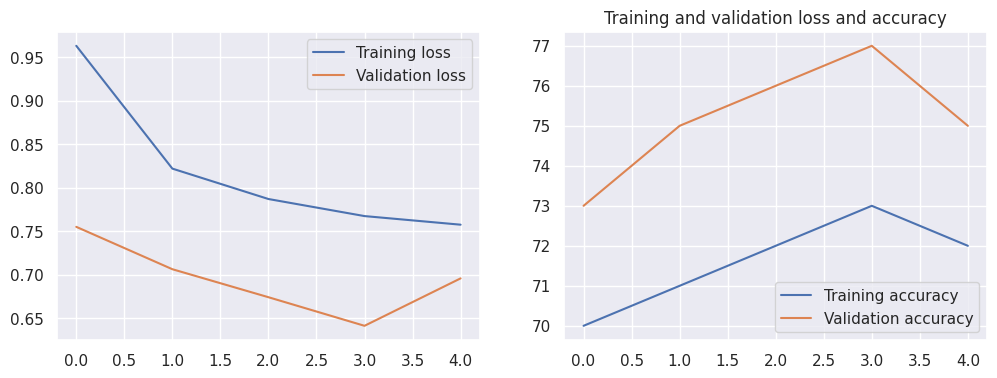

In [ ]:
# changing size so the loaders work with alexnet
train_loader, val_loader, test_loader = prepare_dataset(resize=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_model.classifier[6].parameters(), lr=0.001, momentum=0.9)
epochs = 5

graphing_alex = train(alex_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)

test_accuracy = evaluation(alex_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_alex)

### Discuss your findings:

Our model starts at a much more accurate point compared to the rest of our models, which is to be expected since this model is already trained. There seems to be minimal improvement over five epochs, only increasing accuracy by roughly $3\%$ and decreasing loss by $.15$.



---


## Transfer Learning: Use AlexNet as initialization (10pt)
The second approach to transfer learning is to fine-tune the weights of the pretrained network, in addition to training the new classification layer. In this approach, all network weights
are updated at every training iteration; we simply use the existing AlexNet weights as the “initialization”
for our network (except for the weights in the new classification layer, which will be initialized using
whichever method is specified in the constructor) prior to training on CIFAR-10.

**Note**: Fine-tune AlexNet on
CPU takes an insame amount of time, so we recommend you to use Google Colab, which has free GPU
access. To enable GPU for the notebook: Navigate to Edit→Notebook Settings. select GPU from the
Hardware Accelerator drop-down. For information about training on GPU, check the tutorial.

In [ ]:
full_alex_model = torchvision.models.alexnet(pretrained=True)
full_alex_model.classifier[6] = nn.Linear(4096, 10)

full_alex_model = full_alex_model.to(device)

Epoch 1
Training loss: 1.029723181431605
Training accuracy: 76%
Validation loss: 0.644241724587694
Validation accuracy: 78%

Epoch 2
Training loss: 0.6350020890716802
Training accuracy: 79%
Validation loss: 0.538552088450782
Validation accuracy: 81%

Epoch 3
Training loss: 0.5511154628528113
Training accuracy: 82%
Validation loss: 0.49577557531338706
Validation accuracy: 83%

Epoch 4
Training loss: 0.49994994729587977
Training accuracy: 83%
Validation loss: 0.4600998638551446
Validation accuracy: 84%

Epoch 5
Training loss: 0.46669237745333125
Training accuracy: 84%
Validation loss: 0.43263991384566586
Validation accuracy: 85%

Finished Training
Test accuracy: 85%


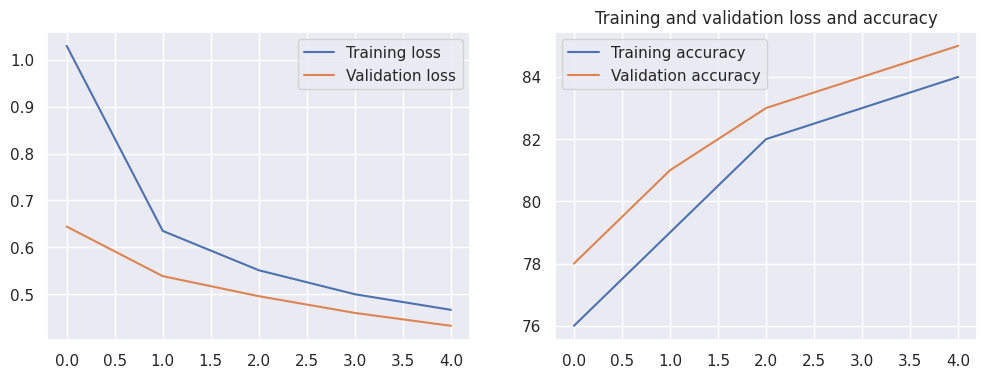

In [ ]:
# changing size so the loaders work with alexnet
train_loader, val_loader, test_loader = prepare_dataset(resize=True)

# reducing learning rate to .0001 for fine tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(full_alex_model.parameters(), lr=0.0001, momentum=0.9)
epochs = 5

graphing_full_alex = train(full_alex_model, train_loader, val_loader,
                                criterion, optimizer, epochs, updates=True)

test_accuracy = evaluation(full_alex_model, test_loader, criterion)
print(f'Test accuracy: {test_accuracy}%')
plots(*graphing_full_alex)

### Discuss your findings:

Fine tuning with the whole model seems to greatly improve accuracy over five epochs, increasing by more than $5\%$ for both validation and training. Loss is also vastly decreased, even compared to its lower starting point.



---


## Adversarial Attacks (15pt)

Modern deep neural networks are brittle and susceptible to small
perturbations to their inputs. This gives rise to adversarial examples, which are nearly indistinguishable
to the human eye but somehow “fool” neural networks into making drastically wrong predictions.

One algorithm to generate such examples is the untargeted fast gradient sign method (FGSM) attack,
which can be described as follows:
Let $x$ be an input image with label $y$, $F$ be a neural network, and $\epsilon$ be a small value (intuitively, an attack rate).

\begin{align}
&\hat{y} = F(x) \\
&L= \text{CrossEntropy}(\hat{y},y) \\
&x' = x+\epsilon \cdot \text{sign}(\nabla_x L)
\end{align}

where $\text{sign}(t) = \frac{t}{|t|}$.  We then use $x'$ as an input to the network. Note that the calculation for $x'$
loosely resembles gradient descent. Intuitively, we are slightly adjusting the input image so that the model is less
likely to predict its true class.

For this part, use your classifier from the third network to do the following steps. As always, please provide all code
and plots.

- Select four images from the train set that have been correctly classified. Visualize them and provide
their labels.

- Implement the untargeted FGSM algorithm. Run one iteration on these images and visualize them:
they should look like the originals.

- Provide the predicted labels for your attacked images. You should have at least one image that is
incorrectly classified. Remark: **FGSM** is a simple attack, but it’s not always effective. In order to
generate successful adversarial examples, you may need to try different values of $\epsilon$ or even different
images, depending on where your classifier excels.

- Explain the significance of the existence of such adversarial examples.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original images and predictions:


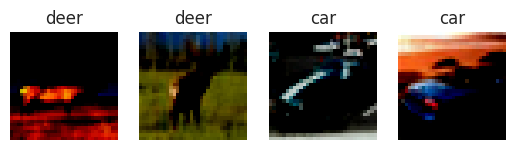

In [42]:
# your code starts here
train_loader, val_loader, test_loader = prepare_dataset(batch_size=1, resize=False)

# Get model
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/ualbany courses/ML Practicum/hw5")

PATH = './cifar_conv.pth'
adv_model = convModel(M=180, k=7, N=13)
adv_model.load_state_dict(torch.load(PATH))
adv_model = adv_model.to(device)

adv_model.eval()
correct_imgs = []
correct_labels = []
predicted_labels = []

# Get 4 correctly classified samples
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = adv_model(images)
    _, predicted = outputs.max(1)

    if predicted == labels:
        correct_imgs.append(images)
        correct_labels.append(labels.item())
        predicted_labels.append(predicted.item())

    if len(correct_imgs) == 4:
        break

# Show original images with labels
print("Original images and predictions:")
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(correct_imgs[i].squeeze().permute(1, 2, 0).cpu())
    plt.title(classes[correct_labels[i]])
    plt.axis("off")
plt.show()


Adversarial predictions:


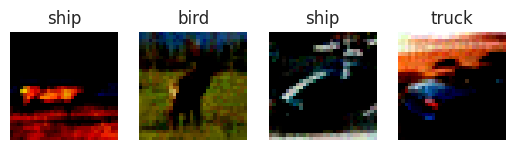

In [43]:
# FGSM attack function
def fgsm_attack(image, label, model, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = torch.nn.functional.cross_entropy(output, label)

    model.zero_grad()
    loss.backward()

    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

# Run FGSM and show adversarial images
epsilon = 0.05
adv_imgs = []
adv_preds = []

print("\nAdversarial predictions:")
for i in range(4):
    img = correct_imgs[i].clone().detach()
    label = torch.tensor([correct_labels[i]]).to(device)
    adv_img = fgsm_attack(img, label, adv_model, epsilon)
    adv_imgs.append(adv_img.detach())

    output = adv_model(adv_img)
    _, adv_pred = output.max(1)
    adv_preds.append(adv_pred.item())

# Show adversarial images
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(adv_imgs[i].squeeze().permute(1, 2, 0).cpu())
    plt.title(classes[adv_preds[i]])
    plt.axis("off")
plt.show()

### Discuss your findings:

Using $ϵ=.1$, for most sets of random images, we get most of the images to predict incorrectly after one step of FGSM. The images appear very similar, albeit much more saturated. With $ϵ=.05$, the images are even more recognizable, but with a higher likelyhood of correct identification.

The takeaway here is that deep neural networks, while powerful at machine vision, tend to overgeneralize important features in the images, which is already commonly seen with cats and dogs being confused most frequently. The subtle change to these features delivered by FGSM showcases this weakness even more so. This can easily be exploited from a security perspective in a facial recognition application of a neural network, where if someone could attack a system in this type of way, they can frequently have the neural network misidentify them.